In [1]:
import sbi4abm.sbi
from sbi4abm.sbi import analysis, utils
from sbi4abm.utils import sampling, plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

/home/zhongmuyao/miniconda3/envs/sbi/lib/python3.10/site-packages/tqdm-4.66.4-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})
plt.rcParams.update({
    'text.latex.preamble':r"\usepackage{amsmath}"+"\n"+r"\usepackage{bm}"
})


In [3]:
hop = np.loadtxt("../../job_data/Hopfield/large_maf_rgcn/1660145547.8277514/samples.txt")

plt.rcParams.update({'font.size':18}) # something about latex font
_ = analysis.pairplot(hop, limits=[[0,5], [0,1], [0,1]], points=[np.array([1., 0.8, 0.5])],
                      points_colors='r', labels=[r"$\rho$", r"$\epsilon$", r"$\lambda$"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

FileNotFoundError: ../../job_data/Hopfield/large_maf_rgcn/1660145547.8277514/samples.txt not found.

In [2]:
from sbi4abm.utils import io

hopf = io.load_task('hop')

Posterior predictives

In [16]:
idxs = np.random.randint(hop.shape[0], size=1000)

In [21]:
pps = []
for idx in idxs:
    data = hopf[0](list(hop[idx]))
    pps.append(data)

In [98]:
n_neg_triads = [] # Average per topic of sentiment values in final time step
glob_clust_coeffs = [] # Global clustering coefficient of networks obtained by keeping edges > 0 otherwise removing
corr_weight_ops = [] # Correlation between the weights of network and overlap in opinion profile
iu1 = np.triu_indices(50)
for pp in pps:
    final = pp[-1].numpy()
    w, s = final[:, :-2], final[:, -2:]
    A = np.sign(w)
    n_neg_triad = np.sum(np.diag(A.dot(A).dot(A)) + 1) / 2
    n_neg_triads.append(n_neg_triad)
    A = (w >= 0).astype(int)
    k = np.sum(A, axis=1)
    glob_clust_coeff = np.trace((A.dot(A)).dot(A)) / np.sum(k*(k-1))
    glob_clust_coeffs.append(glob_clust_coeff)
    overlaps = np.dot(s, s.T)[iu1]/2
    weights = w[iu1]
    corr_weight_op = np.corrcoef(weights, overlaps)
    corr_weight_ops.append(corr_weight_op[0,1])

Prior predictives

In [100]:
pps_ = []
for idx in idxs:
    data = hopf[0](list(hopf[1].sample().tolist()))
    pps_.append(data)

n_neg_triads_ = [] # Average per topic of sentiment values in final time step
glob_clust_coeffs_ = [] # Global clustering coefficient of networks obtained by keeping edges > 0 otherwise removing
corr_weight_ops_ = [] # Correlation between the weights of network and overlap in opinion profile
iu1 = np.triu_indices(50)
for pp in pps_:
    final = pp[-1].numpy()
    w, s = final[:, :-2], final[:, -2:]
    A = np.sign(w)
    n_neg_triad_ = np.sum(np.diag(A.dot(A).dot(A)) + 1) / 2 
    n_neg_triads_.append(n_neg_triad_)
    A = (w >= 0).astype(int)
    k = np.sum(A, axis=1)
    glob_clust_coeff = np.trace((A.dot(A)).dot(A)) / np.sum(k*(k-1))
    glob_clust_coeffs_.append(glob_clust_coeff)
    overlaps = np.dot(s, s.T)[iu1]/2
    weights = w[iu1]
    corr_weight_op = np.corrcoef(weights, overlaps)
    corr_weight_ops_.append(corr_weight_op[0,1])

Observation

In [108]:
final = hopf[2][-1]
w, s = final[:, :-2], final[:, -2:]
A = np.sign(w)
n_neg_triad = np.sum(np.diag((A.dot(A)).dot(A)) + 1) / 2 
A = (w >= 0).astype(int)
k = np.sum(A, axis=1)
glob_clust_coeff = np.trace((A.dot(A)).dot(A)) / np.sum(k*(k-1))
overlaps = np.dot(s, s.T)[iu1]/2
weights = w[iu1]
corr_weight_op = np.corrcoef(weights, overlaps)[0,1]

In [112]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches

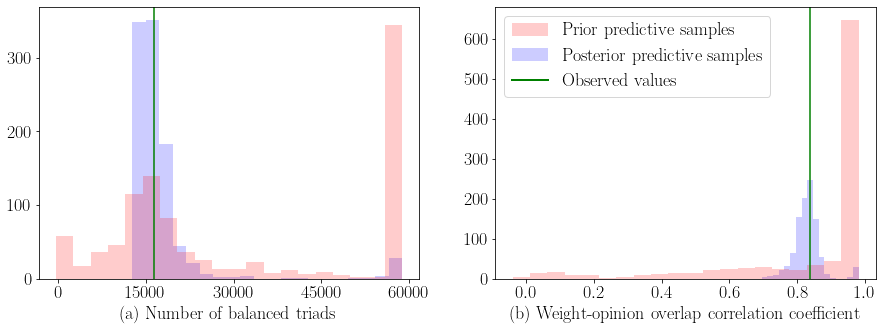

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(n_neg_triads, bins=20, color='b', alpha=0.2)#, density=True)
axes[0].hist(n_neg_triads_, bins=20, color='r', alpha=0.2)#, density=True)
axes[0].axvline(n_neg_triad, c='g')
axes[0].set_xlabel(r"(a) Number of balanced triads", fontsize=18)
axes[0].set_xticks([0, 15000, 30000, 45000, 60000])

axes[1].hist(corr_weight_ops, bins=20, color='b', alpha=0.2)#, density=True)
axes[1].hist(corr_weight_ops_, bins=20, color='r', alpha=0.2)#, density=True)
axes[1].axvline(corr_weight_op, c='g')
axes[1].set_xlabel(r"(b) Weight-opinion overlap correlation coefficient", fontsize=18)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]
axes[1].legend(handles=handles, loc='upper left', ncol=1, fontsize=18)
plt.savefig("./overleaf_plots/graph_posterior_predictives.png", dpi=1000, format='png', bbox_inches='tight')

The (statistics of) the observed data and the data generated from the posterior predictive distribution for the observed data makes the (statistics of) the observed data typical. This suggests that the posterior for the observed data is concentrated in regions of the parameter space that produce dynamics similar to the observed data and is an indication of the success of the posterior estimation pipeline.